### **INSTALL AND IMPORT LIBRARIES**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from huggingface_hub import login, HfFolder, Repository, create_repo, upload_folder, upload_file, hf_hub_download

import requests
import time
import statistics
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import cycle

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

### **UPLOAD MODELS TO HUGGING FACE HUB**

In [ ]:
# Login to Hugging Face
login(token="TOKEN")

# Set repository name
repo_name = "REPO_NAME"

# Create repository if it doesn't exist
try:
    create_repo(repo_name, repo_type="model", private=False)
    print(f"Repository '{repo_name}' created.")
except Exception as e:
    print(f"Repository '{repo_name}' already exists: {e}")

Repository 'ianjure/philnet' created.


In [3]:
# Set final models
textual_model = "fasttext"
heuristic_model = "xgboost"

# Upload textual model
upload_folder(
    folder_path=f"../models/textual/{textual_model}",
    path_in_repo="textual_model",
    repo_id=repo_name,
    repo_type="model"
)
print("Uploaded textual model!")

# Upload heuristic model
upload_folder(
    folder_path=f"../models/heuristic/{heuristic_model}",
    path_in_repo="heuristic_model",
    repo_id=repo_name,
    repo_type="model"
)
print("Uploaded heuristic model!")

model.ftz: 100%|████████████████████████████████████████████████████████████████████| 138M/138M [00:19<00:00, 7.24MB/s]


Uploaded textual model!


Upload 2 LFS files:   0%|                                                                        | 0/2 [00:00<?, ?it/s]

vectorizer.pkl:   0%|                                                                        | 0.00/854 [00:00<?, ?B/s]
model.pkl:   0%|                                                                            | 0.00/706k [00:00<?, ?B/s]
vectorizer.pkl: 100%|███████████████████████████████████████████████████████████████████| 854/854 [00:01<00:00, 797B/s]
model.pkl: 100%|█████████████████████████████████████████████████████████████████████| 706k/706k [00:02<00:00, 324kB/s]
Upload 2 LFS files: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


Uploaded heuristic model!


### **LATENCY AND LOAD TESTING**

In [ ]:
# API endpoint
URL = "API_ENDPOINT_URL"

# Test websites
test_websites = [
    "https://www.mindanews.com",
    "https://balita.org",
    "https://metropolitan.ph",
    "https://www.pinoyweekly.org",
    "https://context.ph",
    "https://www.mindanaoexaminer.com",
    "https://bicolstandard.com",
    "https://easternvisayasmediawithoutborders.com",
    "https://kabayannews.net"
]

headers = {"Content-Type": "application/json"}

# Iterator to cycle through websites
website_cycle = cycle(test_websites)

In [3]:
# ===================
# Utility functions
# ===================
def summarize_latencies(df, total_requests):
    if df.empty:
        summary_df = pd.DataFrame([{
            "Total Requests": total_requests,
            "Successful": 0,
            "Failed": total_requests,
            "Mean Latency (sec)": None,
            "Median Latency (sec)": None,
            "Min Latency (sec)": None,
            "Max Latency (sec)": None,
            "P95 Latency (sec)": None,
            "P99 Latency (sec)": None
        }], index=[total_requests])

        stage_df = pd.DataFrame([{
            "Preprocessing Time (sec)": None,
            "Textual Inference Time (sec)": None,
            "Heuristic Inference Time (sec)": None,
            "Fusion Inference Time (sec)": None,
            "Response Time (sec)": None,
            "Latency (sec)": None,
            "Total Requests": total_requests
        }], index=[total_requests])
        return summary_df, stage_df

    # Latency Summary
    series = df.loc[df["status_code"] == 200, "latency_sec"].dropna()
    summary = {
        "Total Requests": total_requests,
        "Successful": series.size,
        "Failed": total_requests - series.size,
        "Mean Latency (sec)": series.mean(),
        "Median Latency (sec)": series.median(),
        "Min Latency (sec)": series.min(),
        "Max Latency (sec)": series.max(),
        "P95 Latency (sec)": series.quantile(0.95),
        "P99 Latency (sec)": series.quantile(0.99)
    }
    summary_df = pd.DataFrame([summary])

    # Per-Stage Averages
    stage_means = {}
    mapping = {
        "preprocessing_time": "Preprocessing Time (sec)",
        "textual_time": "Textual Inference Time (sec)",
        "heuristic_time": "Heuristic Inference Time (sec)",
        "fusion_time": "Fusion Inference Time (sec)",
        "response_time": "Response Time (sec)"
    }

    for col, label in mapping.items():
        if col in df.columns:
            stage_means[label] = df[col].dropna().mean()
        else:
            stage_means[label] = None

    # Add mean latency and total requests columns
    stage_means["Latency (sec)"] = series.mean()
    stage_means["Total Requests"] = total_requests
    stage_df = pd.DataFrame([stage_means])

    return summary_df, stage_df


# ===================
# Request Functions
# ===================
def parse_response_times(response_json, latency):
    try:
        preprocess = response_json.get("preprocessing_time", 0)
        textual = response_json.get("textual_inference_time", 0)
        heuristic = response_json.get("heuristic_inference_time", 0)
        fusion = response_json.get("fusion_inference_time", 0)
        internal_time = preprocess + textual + heuristic + fusion
        response_time = latency - internal_time if latency > internal_time else None
        return preprocess, textual, heuristic, fusion, response_time
    except Exception as e:
        print(f"[WARN] Failed to parse response times: {e}")
        return None, None, None, None, None


def send_request(session, i):
    url_to_test = next(website_cycle)
    payload = {"url": url_to_test, "source": "API"}
    start = time.perf_counter()
    try:
        response = session.post(URL, json=payload, headers=headers, timeout=10)
        elapsed = time.perf_counter() - start
        preprocess, textual, heuristic, fusion, response_time = parse_response_times(response.json(), elapsed)
        return {
            "request_id": i + 1,
            "url": url_to_test,
            "status_code": response.status_code,
            "latency_sec": elapsed,
            "preprocessing_time": preprocess,
            "textual_time": textual,
            "heuristic_time": heuristic,
            "fusion_time": fusion,
            "response_time": response_time
        }
    except Exception as e:
        return {
            "request_id": i + 1,
            "url": url_to_test,
            "status_code": None,
            "latency_sec": None,
            "error": str(e)
        }


# ==============
# Test Runners
# ==============
def run_sequential_test(num_requests):
    records = []
    with requests.Session() as session:
        for i in range(num_requests):
            records.append(send_request(session, i))
    return pd.DataFrame(records)


def run_concurrent_test(num_requests, concurrency):
    with ThreadPoolExecutor(max_workers=concurrency) as executor:
        futures = [executor.submit(send_request, requests.Session(), i) for i in range(num_requests)]
        results = [f.result() for f in as_completed(futures)]
    return pd.DataFrame(results)


# =========================
# Multi-Size Test Runner
# =========================
def benchmark_request_counts(
    test_values, 
    concurrency=None, 
    vary_concurrency=False, 
    num_trials=1, 
    save_dir="../results"
):
    """
    Runs sequential or concurrent tests across multiple request sizes or concurrency levels.
    - If vary_concurrency=False → test_values = [100, 500, 1000] (number of requests)
    - If vary_concurrency=True  → test_values = [1, 5, 10, 25, 50] (concurrency levels, with fixed request count)

    Saves each trial as a CSV and returns summary + stage-average DataFrames.
    """
    os.makedirs(save_dir, exist_ok=True)
    test_type = 'concurrent' if concurrency or vary_concurrency else 'sequential'

    all_summaries = []
    all_stage_means = []

    for trial in range(num_trials):
        print(f"[INFO] Running trial {trial + 1}/{num_trials} ({test_type})...")

        trial_summaries = []
        trial_stage_means = []

        for val in test_values:
            if vary_concurrency:
                # Fixed total requests, varying concurrency
                total_requests = concurrency or 1000  # default fallback
                curr_concurrency = val
                print(f"  [INFO] Testing concurrency={curr_concurrency}, requests={total_requests}")
                df = run_concurrent_test(total_requests, curr_concurrency)
                summary_df, stage_df = summarize_latencies(df, total_requests)
                summary_df["Concurrency"] = curr_concurrency
                stage_df["Concurrency"] = curr_concurrency
            else:
                # Varying request counts, fixed concurrency
                total_requests = val
                print(f"  [INFO] Testing {total_requests} requests (concurrency={concurrency or 1})")
                if concurrency:
                    df = run_concurrent_test(total_requests, concurrency)
                else:
                    df = run_sequential_test(total_requests)
                summary_df, stage_df = summarize_latencies(df, total_requests)
                summary_df["Concurrency"] = concurrency or 1
                stage_df["Concurrency"] = concurrency or 1

            trial_summaries.append(summary_df)
            trial_stage_means.append(stage_df)

        # Concatenate results per trial
        trial_summary_df = pd.concat(trial_summaries)
        trial_stage_df = pd.concat(trial_stage_means)

        # Save CSV
        summary_csv_path = os.path.join(save_dir, f"{test_type}_trial_{trial + 1}.csv")
        trial_summary_df.to_csv(summary_csv_path, index=False)

        all_summaries.append(trial_summary_df)
        all_stage_means.append(trial_stage_df)

    # Compute averages across trials
    group_key = "Concurrency" if vary_concurrency else "Total Requests"
    final_summary = pd.concat(all_summaries).groupby(group_key).mean().reset_index()
    final_stage_summary = pd.concat(all_stage_means).groupby(group_key).mean().reset_index()

    # Fix fractional counts
    final_summary["Successful"] = final_summary["Successful"].round().astype(int)
    final_summary["Total Requests"] = final_summary["Total Requests"].astype(int)
    final_summary["Failed"] = final_summary["Total Requests"] - final_summary["Successful"]

    return final_summary, final_stage_summary

**SEQUENTIAL REQUESTS**

In [4]:
# Sequential test
request_counts = [50, 100, 500, 1000]
latency_summary, latency_breakdown = benchmark_request_counts(request_counts, concurrency=1, vary_concurrency=False, num_trials=5)
print("Sequential Latency Summary:")
display(latency_summary)

[INFO] Running trial 1/5 (concurrent)...
  [INFO] Testing 50 requests (concurrency=1)
  [INFO] Testing 100 requests (concurrency=1)
  [INFO] Testing 500 requests (concurrency=1)
  [INFO] Testing 1000 requests (concurrency=1)
[INFO] Running trial 2/5 (concurrent)...
  [INFO] Testing 50 requests (concurrency=1)
  [INFO] Testing 100 requests (concurrency=1)
  [INFO] Testing 500 requests (concurrency=1)
  [INFO] Testing 1000 requests (concurrency=1)
[INFO] Running trial 3/5 (concurrent)...
  [INFO] Testing 50 requests (concurrency=1)
  [INFO] Testing 100 requests (concurrency=1)
  [INFO] Testing 500 requests (concurrency=1)
  [INFO] Testing 1000 requests (concurrency=1)
[INFO] Running trial 4/5 (concurrent)...
  [INFO] Testing 50 requests (concurrency=1)
  [INFO] Testing 100 requests (concurrency=1)
  [INFO] Testing 500 requests (concurrency=1)
  [INFO] Testing 1000 requests (concurrency=1)
[INFO] Running trial 5/5 (concurrent)...
  [INFO] Testing 50 requests (concurrency=1)
  [INFO] Testi

,Total Requests,Successful,Failed,Mean Latency (sec),Median Latency (sec),Min Latency (sec),Max Latency (sec),P95 Latency (sec),P99 Latency (sec),Concurrency
0,50,50,0,1.160456,0.948794,0.333831,4.629154,2.505929,4.013144,1.0
1,100,99,1,1.082934,0.881489,0.339267,4.407243,2.358419,3.060519,1.0
2,500,498,2,1.104807,0.882884,0.296370,8.533009,2.499321,3.619453,1.0
3,1000,986,14,1.113351,0.885180,0.299671,7.362685,2.596306,4.322991,1.0


In [5]:
print("Sequential Latency Breakdown:")
display(latency_breakdown)

Sequential Latency Breakdown:


,Total Requests,Preprocessing Time (sec),Textual Inference Time (sec),Heuristic Inference Time (sec),Fusion Inference Time (sec),Response Time (sec),Latency (sec),Concurrency
0,50,0.830300,0.000457,0.001323,0.000002,0.328373,1.160456,1.0
1,100,0.806930,0.000449,0.001181,0.000002,0.296039,1.082934,1.0
2,500,0.823391,0.000454,0.001135,0.000002,0.287102,1.104807,1.0
3,1000,0.811701,0.000452,0.001210,0.000002,0.334166,1.113351,1.0


In [6]:
latency_summary.to_csv("../results/sequential_latency_summary.csv", index=True)
latency_breakdown.to_csv("../results/sequential_latency_breakdown.csv", index=True)

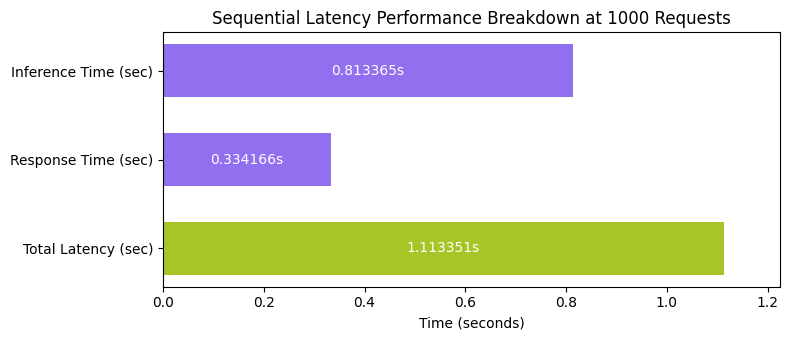

In [8]:
# Get target row
latency_breakdown = pd.read_csv("../results/sequential_latency_breakdown.csv")
latency_breakdown.index = latency_breakdown.index.astype(int)
row = latency_breakdown[latency_breakdown["Total Requests"] == 1000].iloc[0]

# Combine preprocessing + inference
inference_time = (
    row["Preprocessing Time (sec)"] +
    row["Textual Inference Time (sec)"] +
    row["Heuristic Inference Time (sec)"] +
    row["Fusion Inference Time (sec)"]
)
combined = {
    "Inference Time (sec)": inference_time,
    "Response Time (sec)": row["Response Time (sec)"],
    "Total Latency (sec)": row["Latency (sec)"]
}
labels = list(combined.keys())[::-1]
values = list(combined.values())[::-1]

# Highlight total latency
colors = ["#916FEE" if lbl != "Total Latency (sec)" else "#A7C526" for lbl in labels]

# Plot
plt.figure(figsize=(8, 3.5))
bars = plt.barh(labels, values, color=colors, height=0.6)

# Add value labels inside bars
for bar, val in zip(bars, values):
    plt.text(val / 2, bar.get_y() + bar.get_height() / 2,
             f"{val:.6f}s", ha="center", va="center", color="white", fontsize=10)

# Style
plt.title("Sequential Latency Performance Breakdown at 1000 Requests")
plt.xlabel("Time (seconds)")
plt.xlim(0, max(values) * 1.1)
plt.tight_layout()
plt.savefig("../results/sequential_latency_breakdown_1000_requests.png", dpi=300)
plt.show()

**CONCURRENT / PARALLEL REQUESTS**

In [9]:
# Parallel test
concurrency_levels = [5, 10, 50, 100]
load_summary, load_breakdown = benchmark_request_counts(concurrency_levels, concurrency=1000, vary_concurrency=True, num_trials=5)
print("Concurrent Load Test Summary:")
display(load_summary)

[INFO] Running trial 1/5 (concurrent)...
  [INFO] Testing concurrency=5, requests=1000
  [INFO] Testing concurrency=10, requests=1000
  [INFO] Testing concurrency=50, requests=1000
  [INFO] Testing concurrency=100, requests=1000
[INFO] Running trial 2/5 (concurrent)...
  [INFO] Testing concurrency=5, requests=1000
  [INFO] Testing concurrency=10, requests=1000
  [INFO] Testing concurrency=50, requests=1000
  [INFO] Testing concurrency=100, requests=1000
[INFO] Running trial 3/5 (concurrent)...
  [INFO] Testing concurrency=5, requests=1000
  [INFO] Testing concurrency=10, requests=1000
  [INFO] Testing concurrency=50, requests=1000
  [INFO] Testing concurrency=100, requests=1000
[INFO] Running trial 4/5 (concurrent)...
  [INFO] Testing concurrency=5, requests=1000
  [INFO] Testing concurrency=10, requests=1000
  [INFO] Testing concurrency=50, requests=1000
  [INFO] Testing concurrency=100, requests=1000
[INFO] Running trial 5/5 (concurrent)...
  [INFO] Testing concurrency=5, requests=10

,Concurrency,Total Requests,Successful,Failed,Mean Latency (sec),Median Latency (sec),Min Latency (sec),Max Latency (sec),P95 Latency (sec),P99 Latency (sec)
0,5,1000,810,190,1.049701,0.713014,0.296044,11.942976,2.751429,4.905304
1,10,1000,791,209,1.096008,0.766474,0.304721,11.660443,2.569622,4.902643
2,50,1000,770,230,4.886510,3.987563,1.059118,13.332070,8.828039,9.810119
3,100,1000,342,658,5.533565,5.017792,1.142381,11.002482,9.357281,9.981500


In [10]:
print("Concurrent Load Breakdown:")
display(load_breakdown)

Concurrent Load Breakdown:


,Concurrency,Preprocessing Time (sec),Textual Inference Time (sec),Heuristic Inference Time (sec),Fusion Inference Time (sec),Response Time (sec),Latency (sec),Total Requests
0,5,0.565678,0.000355,0.000962,0.000001,0.962553,1.049701,1000.0
1,10,0.544093,0.000339,0.000872,0.000001,1.074472,1.096008,1000.0
2,50,3.139080,0.000332,0.000794,0.000001,1.768148,4.886510,1000.0
3,100,3.501173,0.000328,0.000773,0.000001,1.926316,5.533565,1000.0


In [11]:
load_summary.to_csv("../results/concurrent_load_summary.csv", index=True)
load_breakdown.to_csv("../results/concurrent_load_breakdown.csv", index=True)

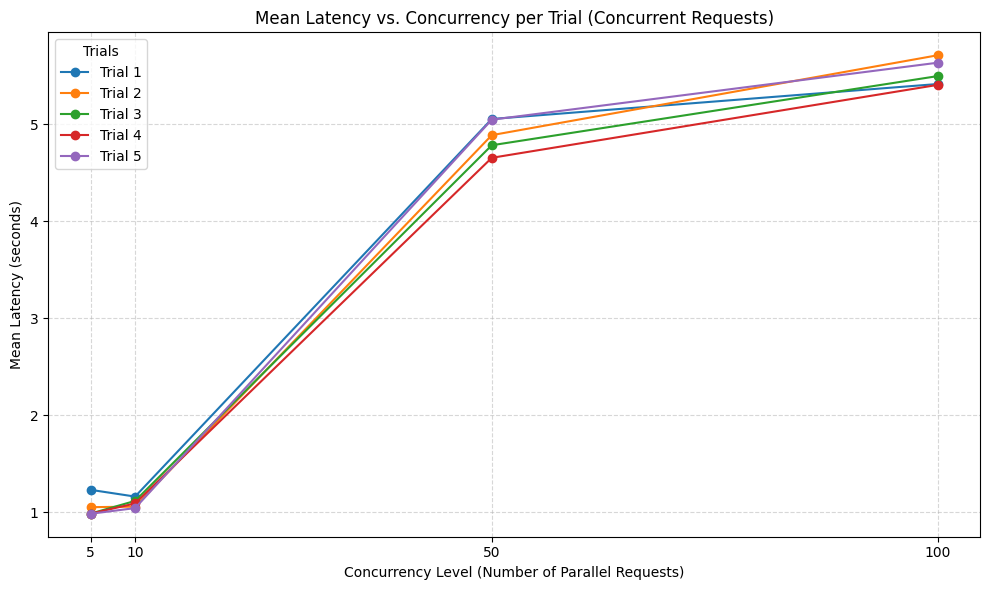

In [12]:
# Path pattern to all trial CSVs
csv_files = sorted(glob.glob("../results/concurrent_trial_*.csv"))

plt.figure(figsize=(10, 6))

# Loop through each trial CSV and plot
for csv_file in csv_files:
    df = pd.read_csv(csv_file)

    # Use 'Concurrency' as x-axis
    x_vals = df["Concurrency"].tolist()
    mean_latency = df["Mean Latency (sec)"].tolist()
    
    # Extract trial number from filename
    trial_number = os.path.basename(csv_file).split("_trial_")[1].split(".csv")[0]
    
    plt.plot(x_vals, mean_latency, marker="o", linestyle="-", label=f"Trial {trial_number}")

plt.xlabel("Concurrency Level (Number of Parallel Requests)")
plt.ylabel("Mean Latency (seconds)")
plt.title("Mean Latency vs. Concurrency per Trial (Concurrent Requests)")
plt.xticks(x_vals)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Trials")
plt.tight_layout()
plt.savefig("../results/concurrent_latency_all_trials.png", dpi=300)
plt.show()

In [17]:
df_1 = pd.read_csv("../results/concurrent_trial_5.csv")
df_1

,Total Requests,Successful,Failed,Mean Latency (sec),Median Latency (sec),Min Latency (sec),Max Latency (sec),P95 Latency (sec),P99 Latency (sec),Concurrency
0,1000,774,226,0.986078,0.675481,0.303673,12.759373,2.374029,5.111788,5
1,1000,776,224,1.044840,0.759216,0.311707,11.734743,2.275572,4.045861,10
2,1000,778,222,5.048362,4.156458,1.085552,13.065454,8.763088,9.761867,50
3,1000,345,655,5.635420,4.997834,0.546058,12.951454,9.571154,10.049751,100
